*Reference code: https://github.com/CVC-Lab/rse_rl/blob/main/RSE_RL.ipynb*


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#imports 
from skimage.util import random_noise
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import cv2
import glob
from cv2 import imshow
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Flatten, Reshape, Softmax, Lambda
from keras.models import Model, Sequential, clone_model
from tensorflow.keras.optimizers import Adam
import torch
import torchvision
from skimage.metrics import structural_similarity as ssim
!pip install sewar
import sewar
from sklearn import cluster
from sklearn import decomposition
from sklearn import manifold


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def read_images(files):
    data = []
    r_dim=(256,256)
    fileList=sorted(glob.glob(files))
    i = 400
    for f1 in fileList:
        i = i + 1
        img = []
        # print("(")
        img = cv2.imread(f1)
        r_img=cv2.resize(img, r_dim, interpolation = cv2.INTER_AREA)
        data.append(r_img)
        if (i == 500):
          break
    return data

def imshow(img, rgb=True):
    if rgb:
        cv2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        cv2.imshow(img)

def get_image_grid(images_np, nrow=8):
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=20, interpolation='lanczos'):
    images_np = np.swapaxes(np.swapaxes(images_np, 1, 3), 2,3)
    n_channels = max(x.shape[0] for x in images_np)
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]
    grid = get_image_grid(images_np, nrow)
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    plt.show()

Load the dataset

In [ ]:
clear_images=read_images('/content/drive/MyDrive/indoor/clear/*.png')
noise_images=read_images('/content/drive/MyDrive/indoor/hazy/*.png')
print(len(clear_images))
print(len(noise_images))

400
400


In [262]:
BLOCK_SIZE = 256
SHAPE = (BLOCK_SIZE, BLOCK_SIZE, 3)

## Model

In [184]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), mean=0,stddev=1.0)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def build_encoder(latent_dim, shape):
    encoder_inputs = keras.Input(shape=shape)
    regularizer = keras.regularizers.l1_l2(0.01)
    x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same", 
                      kernel_regularizer=regularizer)(encoder_inputs)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same",
                      kernel_regularizer=regularizer)(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", 
                      kernel_regularizer=regularizer)(x)
    x = layers.Conv2D(72, 3, activation="relu", strides=1, padding="same",
                      kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)

    z = layers.Dense(latent_dim, name="z")(x)
    z_sig = layers.Dense(latent_dim, activation='softplus')(x)
    encoder = keras.Model(encoder_inputs, [z, z_sig], name="encoder")
    return encoder

def build_decoder(latent_dim, shape):
    latent_inputs = keras.Input(shape=(latent_dim,))
    regularizer = keras.regularizers.l1_l2(0.01)
    x = layers.Dense(shape[0] * shape[1] * 16, activation="relu",
                    kernel_regularizer=regularizer)(latent_inputs)
    x = layers.Reshape((shape[0]//4, shape[1]//4, 256))(x)
    x = layers.Conv2DTranspose(72, 3, activation="relu", strides=1,
                              kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(48, 3, activation="relu", strides=2,
                              kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1,
                               kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, 
                              kernel_regularizer=regularizer, padding="same")(x)
    output = layers.Conv2DTranspose(3, 3, 
                                    activation="sigmoid", 
                                    kernel_regularizer=regularizer, 
                                    padding="same")(x)
    decoder = keras.Model(latent_inputs, output)
    return decoder

def build_transformation(latent_dim):
    model = Sequential()
    model.add(Dense(latent_dim, activation='relu', input_shape=(latent_dim,)))
    model.add(Dense(latent_dim, activation='relu'))
    model.add(Dense(latent_dim, activation='relu'))
    return model

class VAE(tf.keras.Model):
    def __init__(self, latent_dim, shape, encoder=None):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        if encoder==None:
            self.encoder = build_encoder(latent_dim, shape)
        self.transform = build_transformation(latent_dim)
        self.decoder = build_decoder(latent_dim, shape)
        self.sampling = Sampling()
        self.shape = shape
        self.elbo_loss_list = []

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        z = self.transform(z)
        return self.decode(z)

    @tf.function
    def encode(self, x):
        mean, logvar = self.encoder(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        return self.sampling([mean, logvar])
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def elbo_loss(self, z, mu, logvar, target):
        recons = self.decode(z)
        mse = tf.reduce_mean(tf.keras.losses.MSE(target, recons))
        mse *= self.shape[0] * self.shape[1]
        kld = -0.5 * tf.reduce_mean(1 + logvar - tf.math.pow(mu, 2) - tf.math.exp(logvar))
        return mse + kld

    def train_step(self, inputs):
        noise = inputs[0][0]
        clean = inputs[0][1]
        with tf.GradientTape(persistent=True) as tape:
            m_n, var_n = self.encode(noise)
            z_n = self.transform(self.reparameterize(m_n, var_n))
            m_c, var_c = self.encode(clean)
            z_c = self.reparameterize(m_c, var_c)
            latent_loss = tf.reduce_mean(tf.keras.losses.MSE(z_c, z_n))
            elbo_loss = self.elbo_loss(z_n, m_n, var_n, clean)

        tran_grads = tape.gradient(latent_loss, self.transform.trainable_weights)
        # tran_grads = [(tf.clip_by_value(grad, clip_value_min=-1.0, clip_value_max=1.0)).  ##CLIP THE GRADIENTS
        #                           for grad in tran_grads]
        tran_grads = [(tf.clip_by_norm(grad, clip_norm=1.0)) for grad in tran_grads]

        self.optimizer.apply_gradients(zip(tran_grads, self.transform.trainable_weights))

        vae_grads = tape.gradient(elbo_loss, self.trainable_weights)
        # vae_grads = [(tf.clip_by_value(grad, clip_value_min=-1.0, clip_value_max=1.0))
        #                           for grad in vae_grads]
        vae_grads = [(tf.clip_by_norm(grad, clip_norm=1.0)) for grad in vae_grads]
        self.optimizer.apply_gradients(zip(vae_grads, self.trainable_weights))
        self.elbo_loss_list.append(elbo_loss)
        return {
            "elbo_loss": elbo_loss,
            "latent_loss": latent_loss,
        }

In [185]:
def train_model(model, clear_images, noise_images, epoch=1, batch_size=128, lr=0.0001):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),run_eagerly=True)
    model.fit((noise_images,clear_images), epochs=epoch, batch_size=batch_size)
    return model

def save_models(model, file_path):
    model.encoder.save(file_path + 'encoder')
    model.decoder.save(file_path + 'decoder')
    model.transform.save(file_path + 'transform')

def load_models(file_path, latent_dim, shape):
    encoder = keras.models.load_model(file_path + 'encoder',compile=False)
    decoder = keras.models.load_model(file_path + 'decoder',compile=False)
    transform = keras.models.load_model(file_path + 'transform',compile=False)
    model = VAE(latent_dim, shape)
    model.encoder = encoder
    model.decoder = decoder
    model.transform = transform
    return model

LATENT_DIM = 55
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.95
)

In [232]:
model = VAE(LATENT_DIM, SHAPE)
clear_copy = np.array(clear_images)
noise_copy=np.array(noise_images)
clear_copy = clear_copy.astype('float32') / 255.0
noise_copy = noise_copy.astype('float32') / 255.0
model_1 = train_model(model, clear_copy, noise_copy, 100, lr=lr_schedule, batch_size=16)
save_models(model, 'pretrained models/model_1/')

400
400
Epoch 1/100
25/25 [==============================] - 3s 102ms/step - elbo_loss: 6465.3320 - latent_loss: 229.3034
Epoch 2/100
25/25 [==============================] - 3s 101ms/step - elbo_loss: 5211.4218 - latent_loss: 32.8510
Epoch 3/100
25/25 [==============================] - 3s 101ms/step - elbo_loss: 5027.0285 - latent_loss: 70.5787
Epoch 4/100
25/25 [==============================] - 3s 101ms/step - elbo_loss: 4979.8225 - latent_loss: 45.4651
Epoch 5/100
25/25 [==============================] - 3s 102ms/step - elbo_loss: 5065.4233 - latent_loss: 80.4172
Epoch 6/100
25/25 [==============================] - 3s 101ms/step - elbo_loss: 4704.8783 - latent_loss: 216.4635
Epoch 7/100
25/25 [==============================] - 3s 102ms/step - elbo_loss: 4558.3195 - latent_loss: 122.1406
Epoch 8/100
25/25 [==============================] - 3s 103ms/step - elbo_loss: 4061.1051 - latent_loss: 35.3285
Epoch 9/100
25/25 [==============================] - 3s 102ms/step - elbo_loss: 3784.

Text(0, 0.5, 'ELBO Loss')

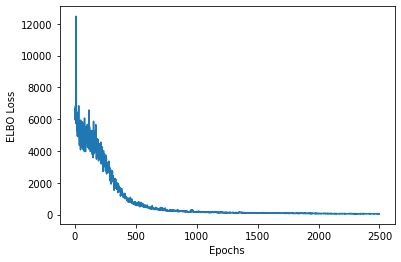

In [233]:
l = []
for i in range(len(model_1.elbo_loss_list)):
    l.append(model_1.elbo_loss_list[i].numpy())

plt.plot(l)
plt.xlabel("Epochs")
plt.ylabel("ELBO Loss")

14.804775851502539
30.589788714735544


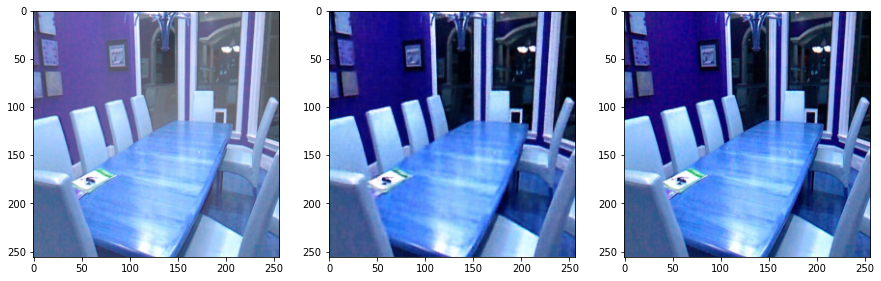

In [263]:
model = load_models('pretrained models/model_1/', LATENT_DIM, SHAPE)
recons = tf.squeeze(model(np.expand_dims(noise_copy[0], 0)))
f,axarr=plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(tf.convert_to_tensor(np.float32(noise_copy[0])))
axarr[1].imshow(tf.convert_to_tensor(np.float32(recons)))
axarr[2].imshow(tf.convert_to_tensor(np.float32(clear_copy[0])))
print(cv2.PSNR(np.float32(noise_copy[0]*255),np.float32(clear_copy[0]*255)))
print(cv2.PSNR(np.float32(recons*255),np.float32(clear_copy[0]*255)))

12.04668082607168
31.64626317614922


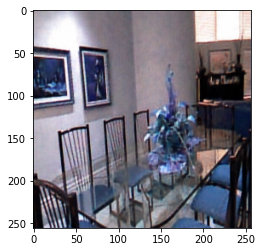

In [264]:
psnr = []
for i in range(len(noise_copy)):
    psnr_val = cv2.PSNR(np.float32(noise_copy[i]*255),np.float32(clear_copy[i]*255))
    psnr.append(psnr_val)
        
psnr_reward = mean(psnr)
print(psnr_reward)
psnr = []
for i in range(len(noise_copy)):
    recons = tf.squeeze(model(np.expand_dims(noise_copy[i], 0)))
    plt.imshow(tf.convert_to_tensor(np.float32(recons)))
    psnr_val = cv2.PSNR(np.float32(recons*255),np.float32(clear_copy[i]*255))
    psnr.append(psnr_val)
        
psnr_reward = mean(psnr)
print(psnr_reward)

In [266]:
clear_images_test=read_images('/content/drive/MyDrive/indoor/clear/*.png')
noise_images_test=read_images('/content/drive/MyDrive/indoor/hazy/*.png')

100
100


In [267]:
clear_copy_test = np.array(clear_images_test)
noise_copy_test = np.array(noise_images_test)
clear_copy_test = clear_copy_test.astype('float32') / 255.0
noise_copy_test = noise_copy_test.astype('float32') / 255.0

100
100


12.81735452707238
30.37460217177887


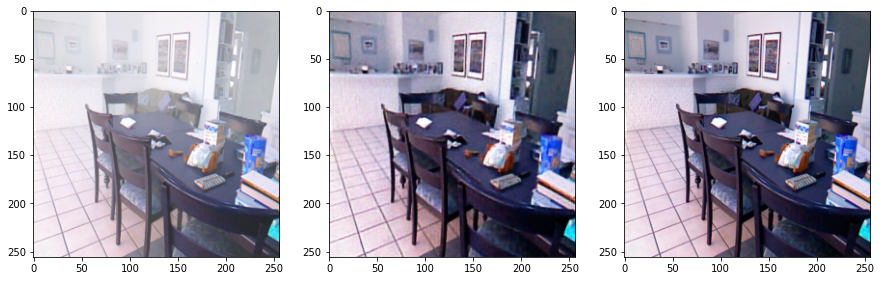

In [268]:
recons = tf.squeeze(model(np.expand_dims(noise_copy_test[99], 0)))
f,axarr=plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(tf.convert_to_tensor(np.float32(noise_copy_test[99])))
axarr[1].imshow(tf.convert_to_tensor(np.float32(recons)))
axarr[2].imshow(tf.convert_to_tensor(np.float32(clear_copy_test[99])))
psnr_val = cv2.PSNR(np.float32(noise_copy_test[99]*255),np.float32(clear_copy_test[99]*255))
print(psnr_val)
print(cv2.PSNR(np.float32(recons*255),np.float32(clear_copy_test[99]*255)))

12.951742030671621
31.390990162977793


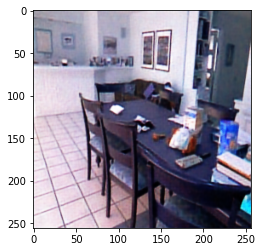

In [269]:
psnr = []
for i in range(len(noise_copy_test)):
    psnr_val = cv2.PSNR(np.float32(noise_copy_test[i]*255),np.float32(clear_copy_test[i]*255))
    psnr.append(psnr_val)
        
psnr_reward = mean(psnr)
print(psnr_reward)
psnr = []
for i in range(len(noise_copy_test)):
    recons = tf.squeeze(model(np.expand_dims(noise_copy_test[i], 0)))
    plt.imshow(tf.convert_to_tensor(np.float32(recons)))
    psnr_val = cv2.PSNR(np.float32(recons*255),np.float32(clear_copy_test[i]*255))
    psnr.append(psnr_val)
        
psnr_reward = mean(psnr)
print(psnr_reward)

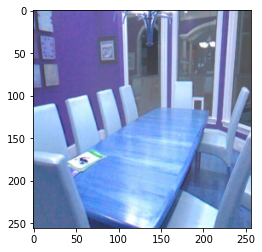

In [215]:
plt.imshow(tf.convert_to_tensor(np.float32(noise_copy[0])))

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


6.725712121786768


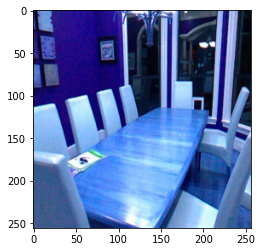

In [240]:
from torchmetrics import PeakSignalNoiseRatio
psnr = PeakSignalNoiseRatio()
print(cv2.PSNR(np.float32(recons*255),np.float32(clear_copy[0]*255)))
plt.imshow(tf.convert_to_tensor(np.float32(clear_copy[0])))

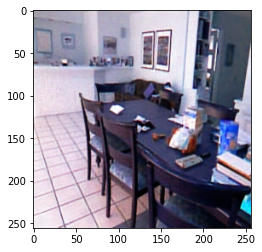

In [241]:
plt.imshow(tf.convert_to_tensor(np.float32(recons)))

## RL

In [242]:
!pip install stable_baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [243]:
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from statistics import mean 

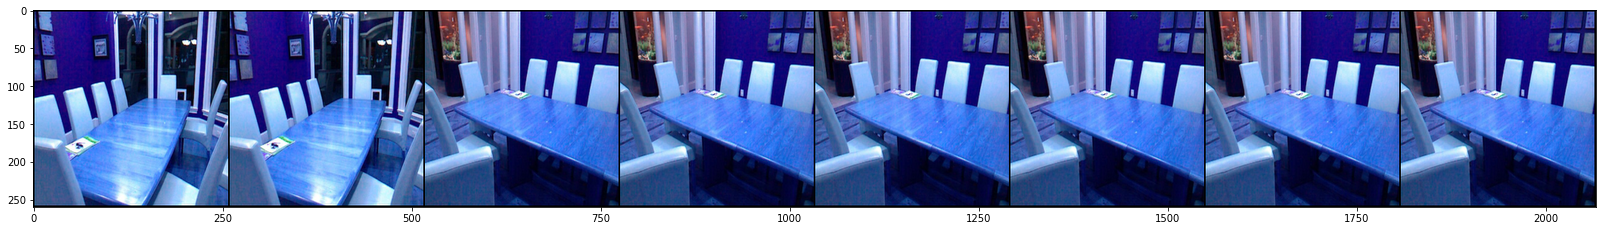

100 100


In [270]:
plot_image_grid(clear_images_test[8:16])
print(len(clear_images_test), len(noise_images_test))

In [278]:
class Img_Enhancing_Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, clear_images, noise_images, model, target_score):
        super(Img_Enhancing_Env, self).__init__()
        self.clear_images = clear_images
        self.noise_images = noise_images
        self.test_images = np.array(clear_images)
        self.target_score = target_score

        self.init_weights = []
        self.init_weights.append(model.transform.trainable_variables)
        self.model = model
        self.reward_range = (-15, 5)
        self.psnr = 0
        self.psnr_list = []
        self.h = len(clear_images[0][0])
        self.current_step = 0
        self.action_space = spaces.Box(low=0.999, high=1.001, shape=(LATENT_DIM,), dtype=np.float32)
        self.observation_space = spaces.Box(0, self.target_score, shape=(1,),dtype=np.float32)
    
    def step(self, action):
        for k in range(len(self.init_weights)):
            for i in range(len(self.init_weights[k])):
                self.model.transform.trainable_variables[i].assign(tf.multiply(self.init_weights[k][i], 
                                                                       action[k*LATENT_DIM: (k+1)*LATENT_DIM]))
        


        psnr = []
        for i in range(len(self.noise_images)):
           recons = tf.squeeze(self.model(np.expand_dims(self.noise_images[i], 0)))
           psnr_val = cv2.PSNR(np.float32(recons*255),np.float32(self.clear_images[i]*255))
           psnr.append(psnr_val)
        

        recons_test = tf.squeeze(self.model(np.expand_dims(self.noise_images[99], 0)))
        plt.imshow(tf.convert_to_tensor(np.float32(recons_test)))
        psnr_val = cv2.PSNR(np.float32(recons_test*255),np.float32(self.clear_images[99]*255))
        print(psnr_val)
        psnr_reward = mean(psnr)
        print(psnr_reward)
        reward = 1.25 * (psnr_reward - self.target_score) + 5
        reward = self.reward_range[1] if reward > self.reward_range[1] else reward
        reward = self.reward_range[0] if reward < self.reward_range[0] else reward
        done = psnr_reward >= self.target_score - 1
        self.current_step += 1
        self.psnr = psnr_reward
        #print(self.current_step, reward, cv2.PSNR(np.float32(clear_copy[0]),np.float32(recons_images.numpy())))
        obs = np.array([psnr_reward])
        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        print('reset')
        self.psnr = 0
        self.current_step = 0
        obs = np.array([0])
        return obs

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        print(f'Step: {self.current_step}')
        print(f'PSNR: {self.psnr}')
        

#model_y = load_models('pretrained models/celeba_y_no/', LATENT_DIM, SHAPE)
env = DummyVecEnv([lambda: Img_Enhancing_Env(clear_copy_test, noise_copy_test, model, 40)])

Using cuda device
reset
29.795865893411886
31.386144211240023
30.47835273905605
31.37778848099127
30.666592147454264
31.32818813863973
30.589192751064257
31.449457816653428
30.17869225451598
31.394682714625883
30.271829016337936
31.33131526099818
30.501181543778493
31.36103609359575
30.019431425691785
31.34599237111995
30.314790882479713
31.4505258001956
30.55013290600446
31.455940962115918
30.30369504978551
31.378875637738975
30.420881895034224
31.437819244514934
30.415291624583226
31.452112087493457
30.49886795531691
31.342480320400366
30.063635766518864
31.34112527517143
30.52838530717686
31.397700314344533
30.065649725703473
31.429740730890227
30.018074829695898
31.30724963743122
30.32169030162414
31.41285085695126
30.15613280299338
31.419928676392217
30.60710756366595
31.441223486725537
30.698576001339347
31.418053329432453
30.60318130082312
31.37382827248888
30.29508111849995
31.412082321914557
30.235188992435475
31.39436496643039
30.561392411050118
31.456955175262262
30.03740844

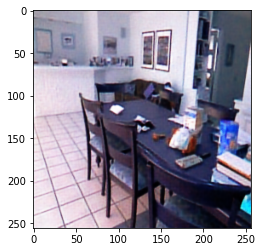

In [279]:
rl_model = SAC('MlpPolicy', env, verbose=1, learning_rate=0.001)
rl_model.learn(total_timesteps=30)